### Working with noisy data

Analytically, it's rather easy to show that the other notebooks work. However, having an imperfect data set will suggest if gained insights are applicable to real-world data.

White gaussian noise is printed on each component. Noise is uncorrelated. Afterwards, a lowpass filter is applied to get rid off any frequency above the main signal's frequency. It remains noise in the frequency range of the signal or lower.

Some notebooks are repeated here with the clue of using noisy data. The amplitude of the noise can be modulated by changing the variable SNR_dB_u and SNR_dB_r, translational and rotational components, respectively. It is the deci-bel strength of the noise in ratio to the signal (SNR = signal to noise ratio). If strain is included, SNR_dB_s modulates it's noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import butter,filtfilt
from scipy.linalg import null_space

In [2]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


In [3]:
index = 1
C, density = get_specific_VTI(medium[index])
#C, density = get_random_C('triclinic',30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [4]:
def awgn(x,SNR_dB):
    L = x.size
    SNR = 10**(SNR_dB/10)                  # SNR to linear scale
    Esym = np.sum(abs(x)**2,axis=None)/(L) # calculate actual symbol energy
    N0 = Esym / SNR                        # find the noise spectral density
    noiseSigma = np.sqrt(N0)               # standard deviation for AWGN Noise
    n = noiseSigma * np.random.randn(x[:,0].size,x[0,:].size) #computed noise
    return x + n                           # received signal

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def lowpass(seis,f,fs,order=5):
    c, nt = np.shape(seis)
    seis_fil = np.zeros((c,nt))
    for i in range(0,c):
        seis_fil[i,:] = butter_lowpass_filter(seis[i,:], f, fs,order )
    return seis_fil

def make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=100.):
    c, nt = np.shape(seis)
    seis_noise = np.zeros((c,nt))
    seis_noise[0:3] = awgn(seis[0:3],SNR_dB_u)
    seis_noise[3:6] = awgn(seis[3:6],SNR_dB_r)
    if c>6:
        seis_noise[6:] = awgn(seis[6:],SNR_dB_s)
    return seis_noise

### Noisy data and low-pass filter

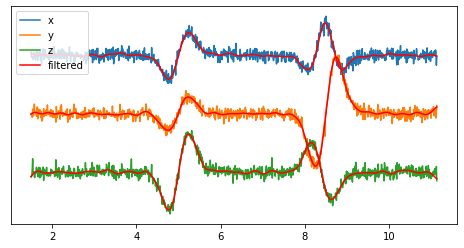

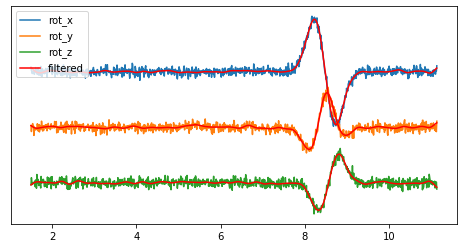

In [5]:
f = 3.
SNR_dB_u = 10
SNR_dB_r = 10
fs = 100.

nus, gammas = get_direction('random',C,1)
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis(v, vel, nus[0], f, fs)
seis_noise = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
seis_fil = lowpass(seis_noise,f,fs)

# plot results
a1 = abs(seis_noise[0:3][:].max())
plt.figure(figsize=(8,4))
plt.plot(t,seis_noise[0,:],label='x')
plt.plot(t,seis_noise[1,:]-a1,label='y')
plt.plot(t,seis_noise[2,:]-2*a1,label='z')
plt.plot(t,seis_fil[0,:],color='red',label='filtered')
plt.plot(t,seis_fil[1,:]-a1,color='red')
plt.plot(t,seis_fil[2,:]-2*a1,color='red')
plt.legend(loc=2)
plt.yticks([])
plt.show()

a2 = seis_noise[3:6][:].max()
plt.figure(figsize=(8,4))
plt.plot(t,seis_noise[3,:],label='rot_x')
plt.plot(t,seis_noise[4,:]-a2,label='rot_y')
plt.plot(t,seis_noise[5,:]-2*a2,label='rot_z')
plt.plot(t,seis_fil[3,:],color='red',label='filtered')
plt.plot(t,seis_fil[4,:]-a2,color='red')
plt.plot(t,seis_fil[5,:]-2*a2,color='red')
plt.legend(loc=2)
plt.yticks([])
plt.show()


### Direction of propagation

#1
Estimated direction of propagation:
Theta: 15.366535798072029
Phi: -104.40915448781845
Actual direction of propagation:
Theta: 36.85243492366483
Phi: -125.27999999999999
Error (order of magnitude):
-0.3981562016822173


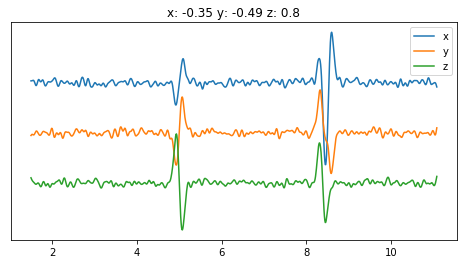

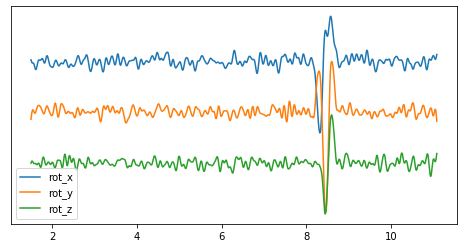

---------------------------------- 
#2
Estimated direction of propagation:
Theta: 67.75926960752597
Phi: 126.52618110837331
Actual direction of propagation:
Theta: 60.99114683252642
Phi: 173.88
Error (order of magnitude):
-0.13537613992575567
---------------------------------- 
#3
Estimated direction of propagation:
Theta: 73.66660091561573
Phi: -132.93560487443116
Actual direction of propagation:
Theta: 68.82920946991608
Phi: -135.72
Error (order of magnitude):
-1.0172371299250473
---------------------------------- 
#4
Estimated direction of propagation:
Theta: 18.72649413698574
Phi: 61.85768063037812
Actual direction of propagation:
Theta: 10.633886218478363
Phi: 175.67999999999998
Error (order of magnitude):
-0.3649367896841711
---------------------------------- 
#5
Estimated direction of propagation:
Theta: 63.79764849529418
Phi: 15.841597732995341
Actual direction of propagation:
Theta: 52.70617711493471
Phi: 7.5600000000000005
Error (order of magnitude):
-0.6409816840890044
-----

In [6]:
f = 10.
fs = 100.
SNR_dB_u = 5.
SNR_dB_r = 0.
N = 5

r2d = 180/np.pi
### generating some traces
for i in range(0,N):
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    seis, t = get_seis(v, vel, nus[0], f, fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
    theta, phi = get_angles(nus[0])
    nu_e = get_propagation_direction(seis)
    theta_e, phi_e = get_angles(nu_e)
    print('#'+str(i+1))
    print('Estimated direction of propagation:')
    print('Theta: '+str(theta_e*r2d))
    print('Phi: '+str(phi_e*r2d))
    print('Actual direction of propagation:')
    print('Theta: '+str(theta*r2d))
    print('Phi: '+str(phi*r2d))
    print('Error (order of magnitude):')
    err = np.sqrt((nus[0][0]-nu_e[0])**2+(nus[0][1]-nu_e[1])**2+(nus[0][2]-nu_e[2])**2)
    print(np.log10(err))
    if i%5==0:
        plotseis(seis,t,nus[0])
    print('---------------------------------- ')


### Propagation direction of single wavefront

C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:480: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


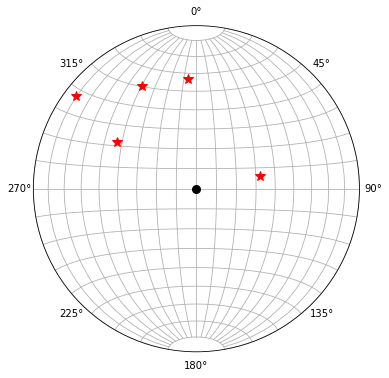

#1


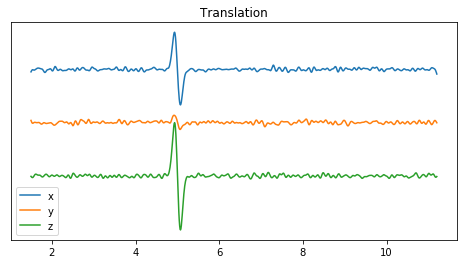

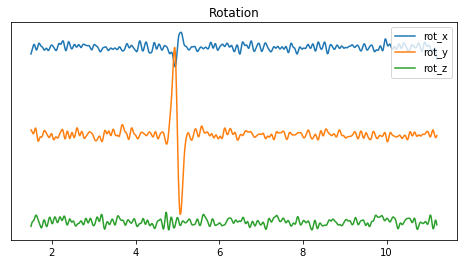

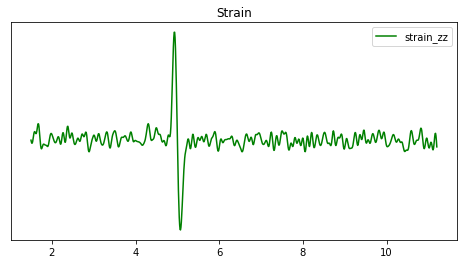

Estimated direction of propagation:
Theta: 31.52572623888762
Phi: 12.407633645592966
Actual direction of propagation:
Theta: 32.52660357042712
Phi: 11.52
Error (order of magnitude):
-1.7143666636725512
---------------------------------- 
#2
Estimated direction of propagation:
Theta: 83.37810820104204
Phi: 146.60826646270309
Actual direction of propagation:
Theta: 82.61457402076368
Phi: 142.55999999999997
Error (order of magnitude):
-1.1465001118989142
---------------------------------- 
#3
Estimated direction of propagation:
Theta: 61.791692561652916
Phi: -112.37930298925836
Actual direction of propagation:
Theta: 56.848661973730565
Phi: 94.31999999999998
Error (order of magnitude):
0.2236788871655078
---------------------------------- 
#4
Estimated direction of propagation:
Theta: 48.538923642363834
Phi: 150.33329777633142
Actual direction of propagation:
Theta: 47.38912877612067
Phi: 149.4
Error (order of magnitude):
-1.6301984318460772
---------------------------------- 
#5
Estimate

In [7]:
f = 10.
fs = 100.
N = 5
SNR_dB_u = 5.
SNR_dB_r = 0.
SNR_dB_s = 0.
wavetype = 'qP' #'qP','qS1','qS2'

nus, gammas = get_direction('random',C,N)
plot_directions(nus)
r2d = 180/np.pi
for i in range(0,len(nus)):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_one_wavetype(wavetype,v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
    seis = lowpass(seis,f,fs)
    
    n,_,_ = get_polarizations(seis,'trans')
    
    it = np.argmax(seis[6,:])
    rx = seis[3,it]
    ry = seis[4,it]
    ezz = seis[6,it]
    
    nu_e = np.zeros(3) 
    nu_e[2] = 1.
    nu_e[1] = 2*rx/ezz + n[1]/n[2]
    nu_e[0] = -2*ry/ezz + n[0]/n[2]

    l = 0
    for j in range(0,3):
        l += nu_e[j]**2
    nu_e = nu_e / np.sqrt(l)
    
    print('#'+str(i+1))
    if i==0:
        plot_7C(seis,t)
    theta_e, phi_e = get_angles(nu_e)
    theta, phi = get_angles(nus[i])
    print('Estimated direction of propagation:')
    print('Theta: '+str(theta_e*r2d))
    print('Phi: '+str(phi_e*r2d))
    print('Actual direction of propagation:')
    print('Theta: '+str(theta*r2d))
    print('Phi: '+str(phi*r2d))
    print('Error (order of magnitude):')
    err = np.sqrt((nus[i][0]-nu_e[0])**2+(nus[i][1]-nu_e[1])**2+(nus[i][2]-nu_e[2])**2)
    print(np.log10(err))
    print('---------------------------------- ')

### Polarizations

In [8]:
f = 10.
fs = 100.
f = 3.
SNR_dB_u = 5.
SNR_dB_r = 0.

N = 5
for i in range(0,N):
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    seis, t = get_seis(v, vel, nus[0], f, fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
    n = get_polarizations(seis,'trans')
    print('#'+str(i+1))
    print('Estimated Polarizations','              -  ','True Polarizations')
    print(n[0],'  -  ',v[:,0])
    print(n[1],'  -  ',v[:,1])
    print(n[2],'  -  ',v[:,2])
    print(' ')
   

#1
Estimated Polarizations               -   True Polarizations
[ 0.86249901  0.49333144 -0.11278099]   -   [ 0.90100905  0.4170882  -0.11924819]
[-0.50047679  0.85958743 -0.06738042]   -   [ 4.20085728e-01 -9.07484425e-01 -5.17428214e-16]
[-0.00361667  0.07605366  0.99709717]   -   [0.10821588 0.05009446 0.99286448]
 
#2
Estimated Polarizations               -   True Polarizations
[-0.47280983 -0.82532067  0.30870156]   -   [ 0.47368923  0.84895825 -0.23428274]
[ 0.86061734 -0.50306291 -0.02682164]   -   [ 8.73262455e-01 -4.87250126e-01 -8.19449931e-17]
[0.14222159 0.19152896 0.97112804]   -   [0.11415429 0.20459032 0.9721685 ]
 
#3
Estimated Polarizations               -   True Polarizations
[ 0.0614922   0.88354796 -0.46428624]   -   [ 0.09342011  0.87127549 -0.48182124]
[ 9.97243569e-01 -6.91921640e-02  4.05160184e-04]   -   [ 9.94300790e-01 -1.06611154e-01  9.53873316e-17]
[-0.0301198  -0.43936376 -0.89780415]   -   [0.05136752 0.47907524 0.87626953]
 
#4
Estimated Polarizations  

In [9]:
#C, density = get_random_C('orthorhombic',30)
C, density = get_specific_VTI(medium[1])

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


### Inversion

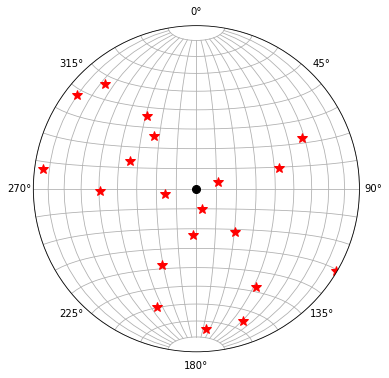

#1
True velocities
3422.011132331252 [2032.2657760239413, 2031.393903996345]
Estimated velocities
[4552.363837599601, 1975.9288369220994, 799.2445656417298]
 
#2
True velocities
3713.307391272166 [2243.681351197881, 1835.8637435929074]
Estimated velocities
[4750.576487255303, 2295.927930518463, 1845.8583577915301]
 
#3
True velocities
3670.6041587094373 [2219.0069374206037, 1877.4033450363854]
Estimated velocities
[2721.9930535987774, 2231.3633193318356, 1842.050485980638]
 
#4
True velocities
3367.3944342709947 [1984.8387662640746, 1936.1748234992579]
Estimated velocities
[3027.22736122057, 1951.7143742206295, 1914.9958744463222]
 
#5
True velocities
3389.3011876650626 [2020.8684518646667, 1987.1162247404006]
Estimated velocities
[2503.075840348917, 2033.226700416211, 2007.763209457676]
 
#6
True velocities
3361.031250686748 [1942.9966184937605, 1899.2490033751512]
Estimated velocities
[2120.0855311059554, 1903.789892847279, 1848.5194452044586]
 
#7
True velocities
3609.3950027314763 

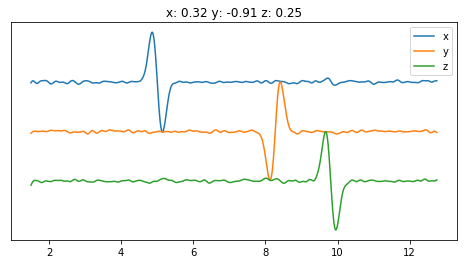

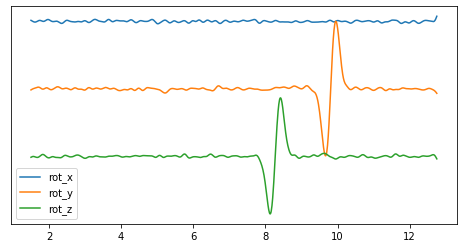

#10
True velocities
3674.843282240978 [2221.4991280883173, 1873.4173802287755]
Estimated velocities
[4842.424677453265, 2153.151736594309, 1851.0090005054124]
 
#13
True velocities
3364.2518540180454 [1860.8465140788599, 1846.164822650692]
Estimated velocities
[4448.005502172887, 1901.6788684981898, 1799.6846673525004]
 
#14
True velocities
3559.5149495297774 [2148.9138793524435, 1969.770420916473]
Estimated velocities
[5741.920930224043, 2171.3604521636553, 2011.0580487521588]
 
#15
True velocities
3361.7357412212077 [1890.4402239006959, 1863.5046309850188]
Estimated velocities
[2533.610939161354, 1846.6674536481933, 1842.144105351868]
 
#16
True velocities
3471.6345936789285 [2081.66673381179, 2020.3346160105689]
Estimated velocities
[2166.67535751654, 2031.9936525662924, 1995.9770660147474]
 
#19
True velocities
3569.8026839695035 [2155.903900288734, 1962.3114348263584]
Estimated velocities
[3462.87986547768, 2121.071711047546, 1927.326334874073]
 
#20
True velocities
3707.047595019

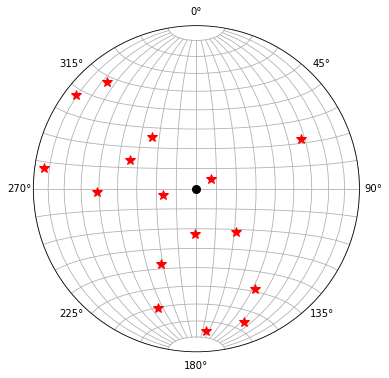

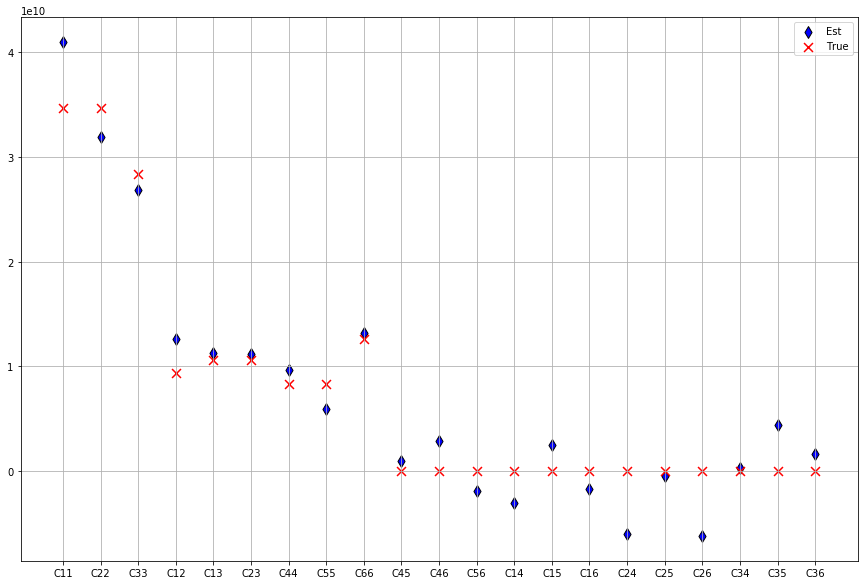

In [10]:
f = 5.
fs = 100.
SNR_dB_u = 10
SNR_dB_r = 10
N = 20
mode = 'triclinic'

d = np.array([])
G = np.array([])
C_e = np.zeros((6,6))
misfits = []
nu_used = []
nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_nu_e = []
all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis(v,vel,nus[i],f,fs) 
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
        
    all_seis.append(seis)
    all_t.append(t)
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    all_nu_e.append(nu_e)
    vel_e,seis_rot,_ = estimate_velocity(seis,nu_e,t)
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 >vel_e[1]:
        pass
    else:
        nu_used.append(nu_e)
        if len(nu_used)%10 == 0:
            plotseis(seis_rot,t,nu_e)
        d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
            
        print('#'+str(i))
        #print('Nullspace dimension: '+str(np.shape(null_space(G))[1]))
        print('True velocities')
        print(max(vel),extract_slower_velocities(vel))
        print('Estimated velocities')
        print(vel_e)
        print(' ')  

Q = np.linalg.inv(np.dot(G.transpose(),G))         
m = np.dot(np.dot(Q,G.transpose()),d)
C_e = sort_elastic_coeff(mode,m)  
eps = np.dot(G,m)
     
print('Estimated Elastic tensor:')
print(C_e[:3,:3]*1e-9)
print(C_e[:3,3:]*1e-9)
print(C_e[3:,3:]*1e-9)
print(' ')
print('Accurate Elastic tensor:')
print(C[:3,:3]*1e-9)
print(C[:3,3:]*1e-9)
print(C[3:,3:]*1e-9)
print(' ')

print(' ')
print('Average misfit:')
print(np.sqrt(np.dot(d-eps,d-eps))/len(nu_used)*1e-9)
print(' ')

print('Used Events: '+str(len(nu_used)))
print('Rate: '+str(round(len(nu_used)/N*100,2))+'%')
print(' ') 

plot_directions(nu_used)

plot_tensor_estimation(C,C_e)

### 6C inversion - error evaluation

There are three sources of errors. First, the estimation of the propagation direction $\nu$. Second, the estimation of the three polarizations $n$ and lastly the velocity estimations of pressure and shear waves.

The estimations:

    1) no analytical results
    2) accurate propagation direction
    3) accurate polarizations
    4) accurate propagation direction & polarizations
    5) accurate qS velocities
    6) accurate qP velocity
    7) accurate qP & qS velocities
    8) accurate velocities and prop. direction
    9) exact solution

In [11]:
C, density = get_specific_VTI(medium[1])

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [12]:
ang1 = 0
ang2 = 0
ang3 = 0
C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

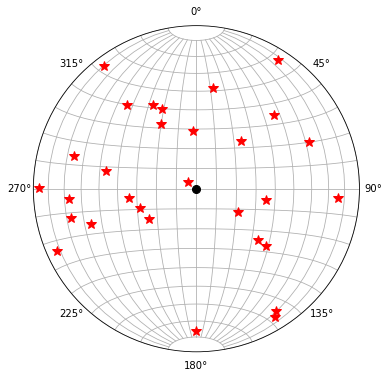

Used Events: 
1) 0.4
2) 0.36666666666666664
3) 0.4
4) 0.36666666666666664
5) 0.4
6) 0.9666666666666667
7) 1.0
8) 1.0
9) 1.0
 
Misfit:
1) 5.916438095179824
2) 4.041073140433091
3) 5.782581782518228
4) 3.971110671825136
5) 5.8721097518190035
6) 1.0123817444807033
7) 1.308706737808605
8) 0.35961536779108044
9) 1.0875899730374526e-14


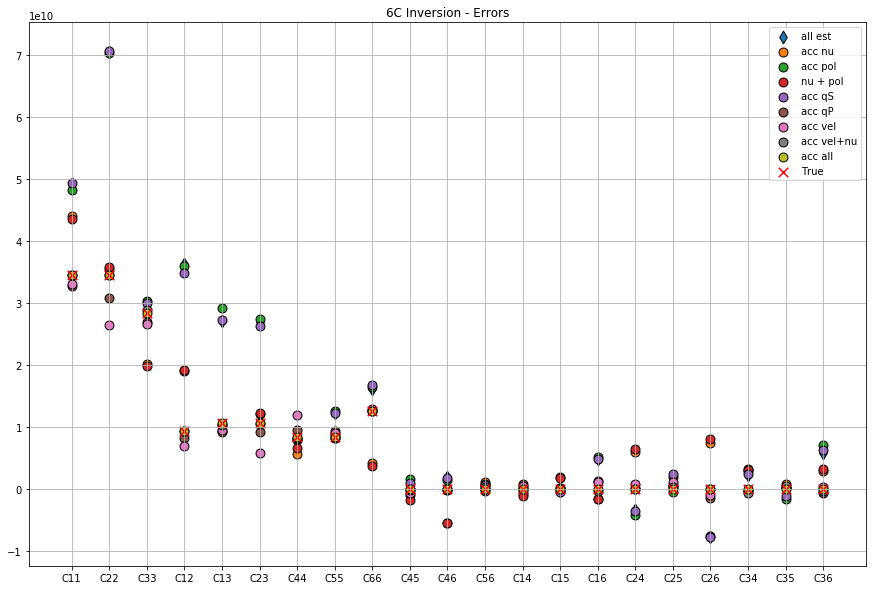

In [13]:
f = 10.
fs = 100.
SNR_dB_u = 5.
SNR_dB_r = 0.
N = 30

## mode: assumed symmetry
mode = 'triclinic'

d1 = np.array([])
d2 = np.array([])
d3 = np.array([])
d4 = np.array([])
d5 = np.array([])
d6 = np.array([])
d7 = np.array([])
d8 = np.array([])
d9 = np.array([])

G1 = np.array([])
G2 = np.array([])
G3 = np.array([])
G4 = np.array([])
G5 = np.array([])
G6 = np.array([])
G7 = np.array([])
G8 = np.array([])
G9 = np.array([])

C_e1 = np.zeros((6,6))
C_e2 = np.zeros((6,6))
C_e3 = np.zeros((6,6))
C_e4 = np.zeros((6,6))
C_e5 = np.zeros((6,6))
C_e6 = np.zeros((6,6))
C_e7 = np.zeros((6,6))
C_e8 = np.zeros((6,6))
C_e9 = np.zeros((6,6))

nu_used1 = []
nu_used2 = []
nu_used3 = []
nu_used4 = []
nu_used5 = []
nu_used6 = []
nu_used7 = []
nu_used8 = []
nu_used9 = []

nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis(v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
    all_seis.append(seis)
    all_t.append(t)
    
    iqP = np.argmax(vel)
    iqS2 = np.argmin(vel)
    for l in range(0,3):
        if iqP!=l and iqS2!=l:
            iqS1 = l
    
    #1) no analytical results
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used1.append(nu_e)
        d1,G1 = add_new_data(mode,d1,G1,nu_e,vel_e,n_trans,density)
        
    #2) accurate propagation direction        
    n_trans = get_polarizations(seis,'trans')
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used2.append(nu_e)
        d2,G2 = add_new_data(mode,d2,G2,nu_e,vel_e,n_trans,density)
    
    #3) accurate polarizations

    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used3.append(nu_e)
        d3,G3 = add_new_data(mode,d3,G3,nu_e,vel_e,n_trans,density)
        
    #4) accurate propagation direction & polarizations
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used4.append(nu_e)
        d4,G4 = add_new_data(mode,d4,G4,nu_e,vel_e,n_trans,density)
        
    #5) accurate qS velocities
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used5.append(nu_e)
        d5,G5 = add_new_data(mode,d5,G5,nu_e,vel_e,n_trans,density)
    
    #6) accurate qP velocity
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)
    
    vel_e[0] = vel[iqP]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used6.append(nu_e)
        d6,G6 = add_new_data(mode,d6,G6,nu_e,vel_e,n_trans,density)
        
    #7) accurate qP & qS velocities 
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used7.append(nu_e)
        d7,G7 = add_new_data(mode,d7,G7,nu_e,vel_e,n_trans,density)
        
    #9) Accurate Solution
    
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used8.append(nu_e)
        d8,G8 = add_new_data(mode,d8,G8,nu_e,vel_e,n_trans,density)
    
    #8) accurate velocities and prop. direction
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used9.append(nu_e)
        d9,G9 = add_new_data(mode,d9,G9,nu_e,vel_e,n_trans,density)

    

Q1 = np.linalg.inv(np.dot(G1.transpose(),G1))         
m1 = np.dot(np.dot(Q1,G1.transpose()),d1)
C_e1 = sort_elastic_coeff(mode,m1)  
eps1 = np.dot(G1,m1) 

Q2 = np.linalg.inv(np.dot(G2.transpose(),G2))         
m2 = np.dot(np.dot(Q2,G2.transpose()),d2)
C_e2 = sort_elastic_coeff(mode,m2)  
eps2 = np.dot(G2,m2)

Q3 = np.linalg.inv(np.dot(G3.transpose(),G3))         
m3 = np.dot(np.dot(Q3,G3.transpose()),d3)
C_e3 = sort_elastic_coeff(mode,m3)  
eps3 = np.dot(G3,m3)

Q4 = np.linalg.inv(np.dot(G4.transpose(),G4))         
m4 = np.dot(np.dot(Q4,G4.transpose()),d4)
C_e4 = sort_elastic_coeff(mode,m4)  
eps4 = np.dot(G4,m4)

Q5 = np.linalg.inv(np.dot(G5.transpose(),G5))         
m5 = np.dot(np.dot(Q5,G5.transpose()),d5)
C_e5 = sort_elastic_coeff(mode,m5)  
eps5 = np.dot(G5,m5)

Q6 = np.linalg.inv(np.dot(G6.transpose(),G6))         
m6 = np.dot(np.dot(Q6,G6.transpose()),d6)
C_e6 = sort_elastic_coeff(mode,m6)  
eps6 = np.dot(G6,m6)

Q7 = np.linalg.inv(np.dot(G7.transpose(),G7))         
m7 = np.dot(np.dot(Q7,G7.transpose()),d7)
C_e7 = sort_elastic_coeff(mode,m7)  
eps7 = np.dot(G7,m7)

Q8 = np.linalg.inv(np.dot(G8.transpose(),G8))         
m8 = np.dot(np.dot(Q8,G8.transpose()),d8)
C_e8 = sort_elastic_coeff(mode,m8)  
eps8 = np.dot(G8,m8)

Q9 = np.linalg.inv(np.dot(G9.transpose(),G9))         
m9 = np.dot(np.dot(Q9,G9.transpose()),d9)
C_e9 = sort_elastic_coeff(mode,m9)  
eps9 = np.dot(G9,m9)
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

C_e1 = rotate_C(C_e1,3,-ang3)
C_e1 = rotate_C(C_e1,2,-ang2)
C_e1 = rotate_C(C_e1,1,-ang1)

C_e2 = rotate_C(C_e2,3,-ang3)
C_e2 = rotate_C(C_e2,2,-ang2)
C_e2 = rotate_C(C_e2,1,-ang1)

C_e3 = rotate_C(C_e3,3,-ang3)
C_e3 = rotate_C(C_e3,2,-ang2)
C_e3 = rotate_C(C_e3,1,-ang1)

C_e4 = rotate_C(C_e4,3,-ang3)
C_e4 = rotate_C(C_e4,2,-ang2)
C_e4 = rotate_C(C_e4,1,-ang1)

C_e5 = rotate_C(C_e5,3,-ang3)
C_e5 = rotate_C(C_e5,2,-ang2)
C_e5 = rotate_C(C_e5,1,-ang1)

C_e6 = rotate_C(C_e6,3,-ang3)
C_e6 = rotate_C(C_e6,2,-ang2)
C_e6 = rotate_C(C_e6,1,-ang1)

C_e7 = rotate_C(C_e7,3,-ang3)
C_e7 = rotate_C(C_e7,2,-ang2)
C_e7 = rotate_C(C_e7,1,-ang1)

C_e8 = rotate_C(C_e8,3,-ang3)
C_e8 = rotate_C(C_e8,2,-ang2)
C_e8 = rotate_C(C_e8,1,-ang1)

C_e9 = rotate_C(C_e9,3,-ang3)
C_e9 = rotate_C(C_e9,2,-ang2)
C_e9 = rotate_C(C_e9,1,-ang1)

print('Used Events: ')
print('1) '+str(len(nu_used1)/N))
print('2) '+str(len(nu_used2)/N))
print('3) '+str(len(nu_used3)/N))
print('4) '+str(len(nu_used4)/N))
print('5) '+str(len(nu_used5)/N))
print('6) '+str(len(nu_used6)/N))
print('7) '+str(len(nu_used7)/N))
print('8) '+str(len(nu_used9)/N))
print('9) '+str(len(nu_used8)/N))
print(' ')
    
print('Misfit:')
print('1) '+str(np.sqrt(np.dot(d1-eps1,d1-eps1))*1e-9/len(nu_used1)))
print('2) '+str(np.sqrt(np.dot(d2-eps2,d2-eps2))*1e-9/len(nu_used2)))
print('3) '+str(np.sqrt(np.dot(d3-eps3,d3-eps3))*1e-9/len(nu_used3)))
print('4) '+str(np.sqrt(np.dot(d4-eps4,d4-eps4))*1e-9/len(nu_used4)))
print('5) '+str(np.sqrt(np.dot(d5-eps5,d5-eps5))*1e-9/len(nu_used5)))
print('6) '+str(np.sqrt(np.dot(d6-eps6,d6-eps6))*1e-9/len(nu_used6)))
print('7) '+str(np.sqrt(np.dot(d7-eps7,d7-eps7))*1e-9/len(nu_used7)))
print('8) '+str(np.sqrt(np.dot(d9-eps9,d9-eps9))*1e-9/len(nu_used9)))
print('9) '+str(np.sqrt(np.dot(d8-eps8,d8-eps8))*1e-9/len(nu_used8)))



param = ['C11','C22','C33','C12','C13','C23','C44','C55','C66','C45','C46','C56','C14','C15','C16','C24',\
         'C25','C26','C34','C35','C36']
c_true = [C[0,0],C[1,1],C[2,2],C[0,1],C[0,2],C[1,2],C[3,3],C[4,4],C[5,5],C[3,4],C[3,5],C[4,5],C[0,3],C[0,4],\
          C[0,5],C[1,3],C[1,4],C[1,5],C[2,3],C[2,4],C[2,5]]
c_est1 = [C_e1[0,0],C_e1[1,1],C_e1[2,2],C_e1[0,1],C_e1[0,2],C_e1[1,2],C_e1[3,3],C_e1[4,4],C_e1[5,5],C_e1[3,4],\
         C_e1[3,5],C_e1[4,5],C_e1[0,3],C_e1[0,4],C_e1[0,5],C_e1[1,3],C_e1[1,4],C_e1[1,5],C_e1[2,3],C_e1[2,4],\
         C_e1[2,5]]
c_est2 = [C_e2[0,0],C_e2[1,1],C_e2[2,2],C_e2[0,1],C_e2[0,2],C_e2[1,2],C_e2[3,3],C_e2[4,4],C_e2[5,5],C_e2[3,4],\
          C_e2[3,5],C_e2[4,5],C_e2[0,3],C_e2[0,4],C_e2[0,5],C_e2[1,3],C_e2[1,4],C_e2[1,5],C_e2[2,3],C_e2[2,4],\
          C_e2[2,5]]
c_est3 = [C_e3[0,0],C_e3[1,1],C_e3[2,2],C_e3[0,1],C_e3[0,2],C_e3[1,2],C_e3[3,3],C_e3[4,4],C_e3[5,5],C_e3[3,4],\
          C_e3[3,5],C_e3[4,5],C_e3[0,3],C_e3[0,4],C_e3[0,5],C_e3[1,3],C_e3[1,4],C_e3[1,5],C_e3[2,3],C_e3[2,4],\
          C_e3[2,5]]
c_est4 = [C_e4[0,0],C_e4[1,1],C_e4[2,2],C_e4[0,1],C_e4[0,2],C_e4[1,2],C_e4[3,3],C_e4[4,4],C_e4[5,5],C_e4[3,4],\
          C_e4[3,5],C_e4[4,5],C_e4[0,3],C_e4[0,4],C_e4[0,5],C_e4[1,3],C_e4[1,4],C_e4[1,5],C_e4[2,3],C_e4[2,4],\
          C_e4[2,5]]
c_est5 = [C_e5[0,0],C_e5[1,1],C_e5[2,2],C_e5[0,1],C_e5[0,2],C_e5[1,2],C_e5[3,3],C_e5[4,4],C_e5[5,5],C_e5[3,4],\
          C_e5[3,5],C_e5[4,5],C_e5[0,3],C_e5[0,4],C_e5[0,5],C_e5[1,3],C_e5[1,4],C_e5[1,5],C_e5[2,3],C_e5[2,4],\
          C_e5[2,5]]
c_est6 = [C_e6[0,0],C_e6[1,1],C_e6[2,2],C_e6[0,1],C_e6[0,2],C_e6[1,2],C_e6[3,3],C_e6[4,4],C_e6[5,5],C_e6[3,4],\
          C_e6[3,5],C_e6[4,5],C_e6[0,3],C_e6[0,4],C_e6[0,5],C_e6[1,3],C_e6[1,4],C_e6[1,5],C_e6[2,3],C_e6[2,4],\
          C_e6[2,5]]
c_est7 = [C_e7[0,0],C_e7[1,1],C_e7[2,2],C_e7[0,1],C_e7[0,2],C_e7[1,2],C_e7[3,3],C_e7[4,4],C_e7[5,5],C_e7[3,4],\
          C_e7[3,5],C_e7[4,5],C_e7[0,3],C_e7[0,4],C_e7[0,5],C_e7[1,3],C_e7[1,4],C_e7[1,5],C_e7[2,3],C_e7[2,4],\
          C_e7[2,5]]
c_est8 = [C_e8[0,0],C_e8[1,1],C_e8[2,2],C_e8[0,1],C_e8[0,2],C_e8[1,2],C_e8[3,3],C_e8[4,4],C_e8[5,5],C_e8[3,4],\
          C_e8[3,5],C_e8[4,5],C_e8[0,3],C_e8[0,4],C_e8[0,5],C_e8[1,3],C_e8[1,4],C_e8[1,5],C_e8[2,3],C_e8[2,4],\
          C_e8[2,5]]

c_est9 = [C_e9[0,0],C_e9[1,1],C_e9[2,2],C_e9[0,1],C_e9[0,2],C_e9[1,2],C_e9[3,3],C_e9[4,4],C_e9[5,5],C_e9[3,4],\
          C_e9[3,5],C_e9[4,5],C_e9[0,3],C_e9[0,4],C_e9[0,5],C_e9[1,3],C_e9[1,4],C_e9[1,5],C_e9[2,3],C_e9[2,4],\
          C_e9[2,5]]

plt.figure(figsize=(15,10))
plt.title('6C Inversion - Errors')
plt.scatter(param,c_est1,label='all est',marker='d',s=80,edgecolors='black')
plt.scatter(param,c_est2,label='acc nu',s=80,edgecolors='black')
plt.scatter(param,c_est3,label='acc pol',s=80,edgecolors='black')
plt.scatter(param,c_est4,label='nu + pol',s=80,edgecolors='black')
plt.scatter(param,c_est5,label='acc qS',s=80,edgecolors='black')
plt.scatter(param,c_est6,label='acc qP',s=80,edgecolors='black')
plt.scatter(param,c_est7,label='acc vel',s=80,edgecolors='black')
plt.scatter(param,c_est9,label='acc vel+nu',s=80,edgecolors='black')
plt.scatter(param,c_est8,label='acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()

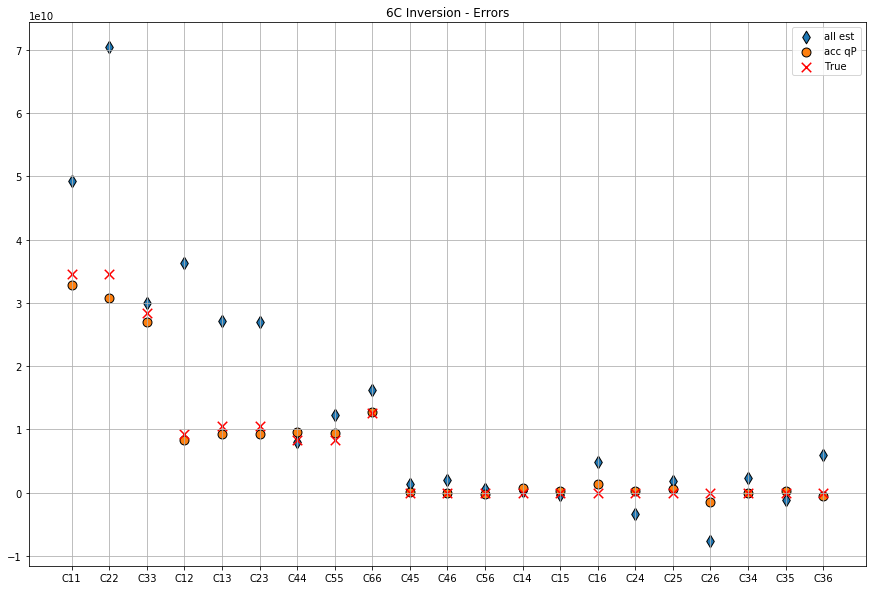

In [14]:
plt.figure(figsize=(15,10))
plt.title('6C Inversion - Errors')
plt.scatter(param,c_est1,label='all est',marker='d',s=80,edgecolors='black')
#plt.scatter(param,c_est2,label='acc nu',s=80,edgecolors='black')
#plt.scatter(param,c_est3,label='acc pol',s=80,edgecolors='black')
#plt.scatter(param,c_est4,label='nu + pol',s=80,edgecolors='black')
#plt.scatter(param,c_est5,label='acc qS',s=80,edgecolors='black')
plt.scatter(param,c_est6,label='acc qP',s=80,edgecolors='black')
#plt.scatter(param,c_est7,label='acc vel',s=80,edgecolors='black')
#plt.scatter(param,c_est9,label='acc vel+nu',s=80,edgecolors='black')
#plt.scatter(param,c_est8,label='acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()